 # Decion based models. From decision Tree to Random Forest

### Load the Boston Dataset and Prepare the Data
- Load the Boston dataset from sklearn (`sklearn.datasets.load_boston()`).
- Separate the features and the target variable, which is 'medv' in this case.
- Analyse the dataset and process different necessary transformations of the data.
- Split the dataset

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  
count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64


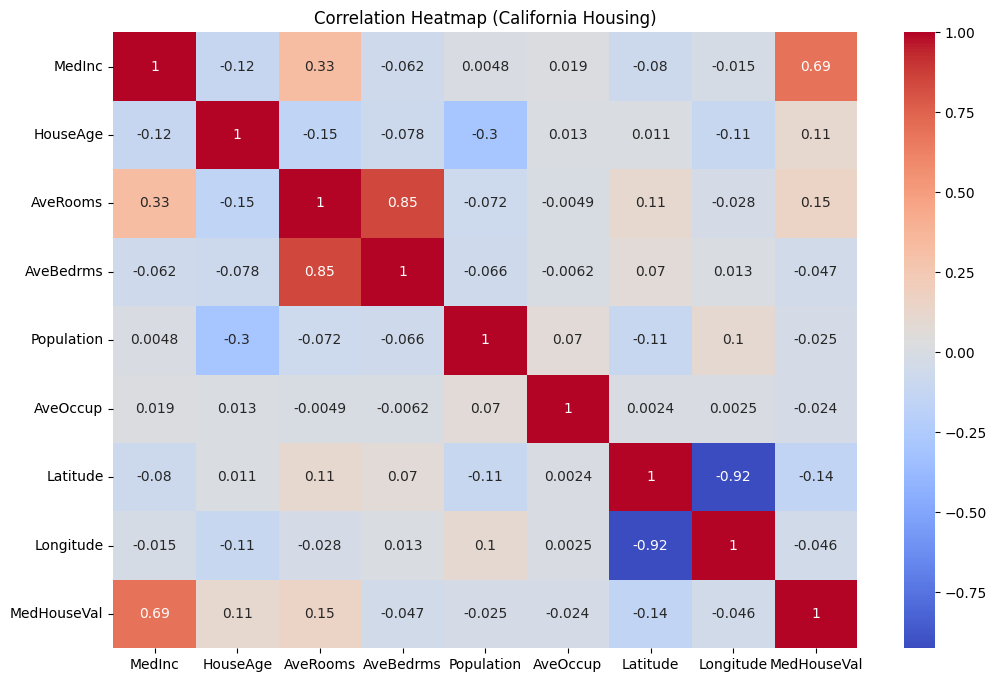

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = pd.Series(california.target, name='MedHouseVal')


print(X.head())
print(y.describe())


corr_matrix = X.copy()
corr_matrix['MedHouseVal'] = y

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (California Housing)")
plt.show()


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


###  Fit the Regression Tree
- Fit a decision tree to the training data.
- Try to vizualize the behavior of the DT while changing parameters

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score  # <-- Бұл қажет
import matplotlib.pyplot as plt

# Базалық модель (default параметрлермен)
dt_default = DecisionTreeRegressor(random_state=42)
dt_default.fit(X_train, y_train)

# Бағалау
y_pred_default = dt_default.predict(X_test)
print("Default Tree R²:", r2_score(y_test, y_pred_default))


Default Tree R²: 0.6228111330554302


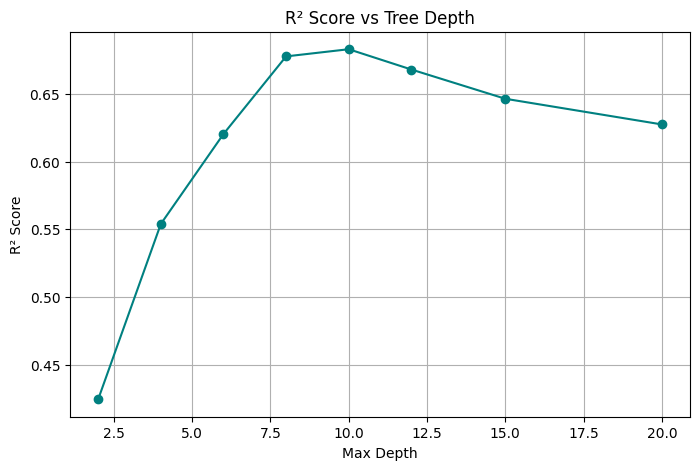

In [ ]:
depths = [2, 4, 6, 8, 10, 12, 15, 20]
r2_scores = []

for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    r2_scores.append(r2)

# Визуализация
plt.figure(figsize=(8, 5))
plt.plot(depths, r2_scores, marker='o', linestyle='-', color='teal')
plt.title("R² Score vs Tree Depth")
plt.xlabel("Max Depth")
plt.ylabel("R² Score")
plt.grid(True)
plt.show()


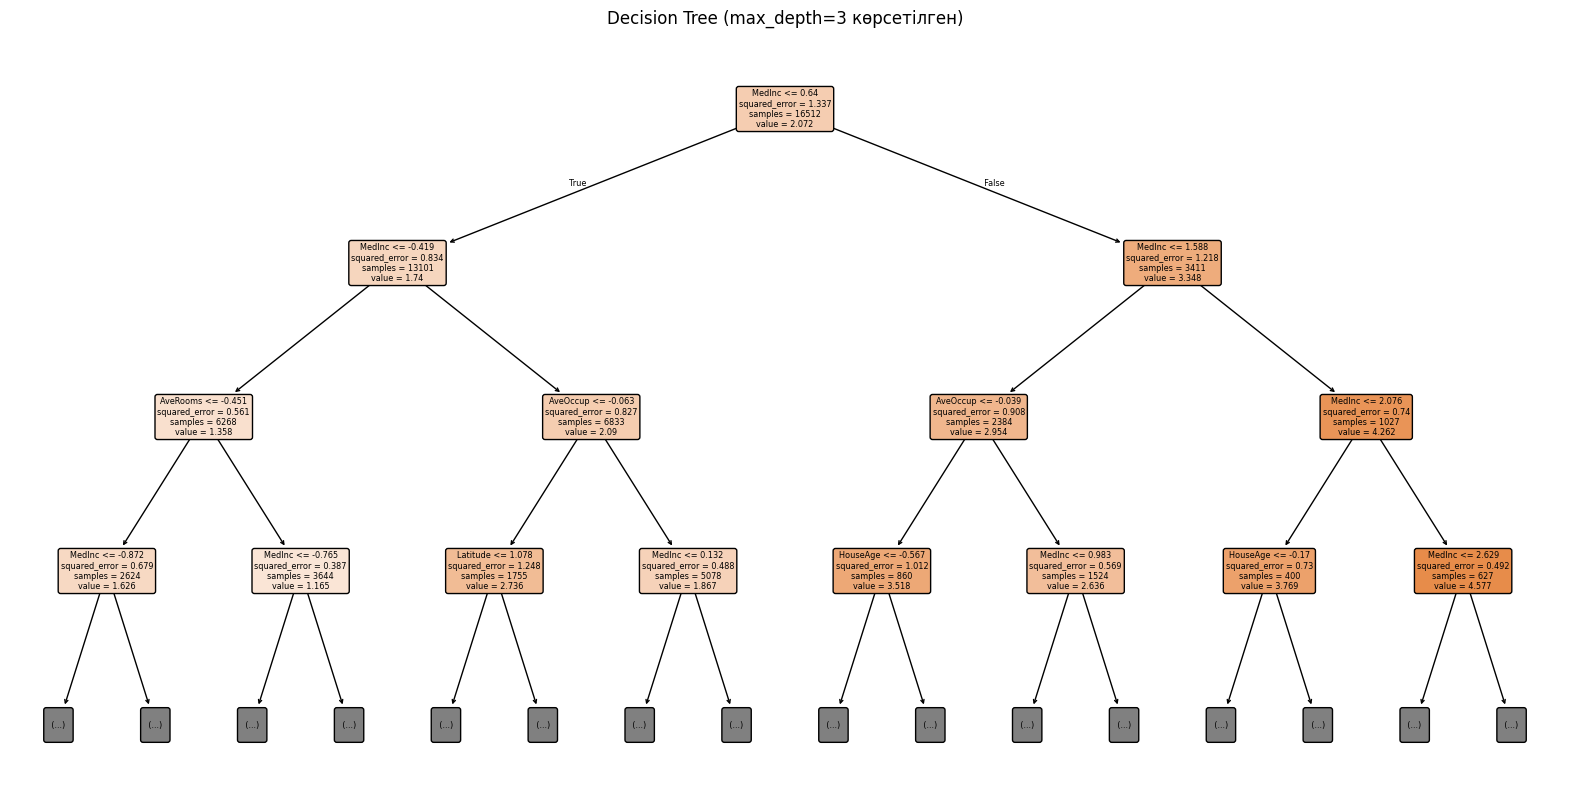

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(
    dt_default,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    max_depth=3  # көрсету тереңдігін шектейміз
)
plt.title("Decision Tree (max_depth=3 көрсетілген)")
plt.show()


### Perform Cost Complexity Pruning
- Apply cost complexity pruning to the regression tree using the appropriate library function : `cost_complexity_pruning_path()`
- Determine the optimal pruning parameter `ccp_alpha` through cross-validation

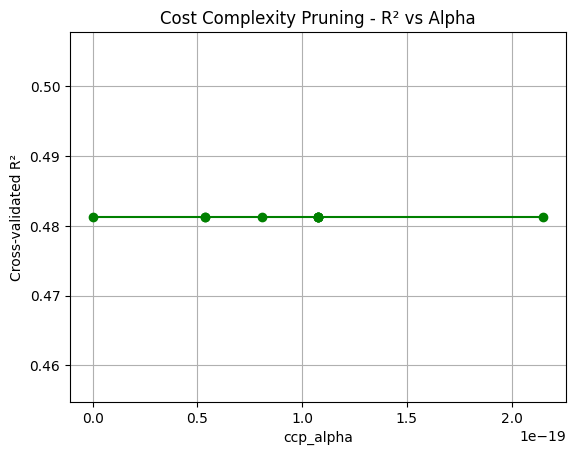

Optimal ccp_alpha: 0.00000


In [3]:
# Reduce dataset size for faster testing
X_train, _, y_train, _ = train_test_split(X, y, test_size=0.8, random_state=42)

# Reduce the number of cross-validation folds
cv_results = []
for ccp_alpha in ccp_alphas[:10]:  # Limit to first 10 alphas
    model = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    
    # Perform 3-fold cross-validation for speed
    cv_score = cross_val_score(model, X_train, y_train, cv=3, scoring='r2', n_jobs=-1)
    cv_results.append(np.mean(cv_score))

cv_results = np.array(cv_results)

# Plot and print the results as usual
plt.plot(ccp_alphas[:10], cv_results, marker='o', color='green')
plt.xlabel("ccp_alpha")
plt.ylabel("Cross-validated R²")
plt.title("Cost Complexity Pruning - R² vs Alpha")
plt.grid(True)
plt.show()

best_ccp_alpha = ccp_alphas[np.argmax(cv_results)]
print(f"Optimal ccp_alpha: {best_ccp_alpha:.5f}")


### Analyze the results
- Use the best estimator obtained from cross-validation to make predictions on the test set
- Utilize the `predict()` method of the best estimator to generate predictions for the test data
- Evaluate the Performance of the Model on the Test Set
- Plot the tree to see if its interpretable

In [6]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Use a smaller subset for faster execution
X_train_subset = X_train[:1000]
y_train_subset = y_train[:1000]

# Initialize the best model with the optimal ccp_alpha and limit the depth of the tree
best_model = DecisionTreeRegressor(random_state=42, ccp_alpha=best_ccp_alpha, max_depth=5)

# Train the model on the smaller subset of data
best_model.fit(X_train_subset, y_train_subset)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the performance of the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Set Mean Squared Error: {mse:.2f}")
print(f"Test Set R²: {r2:.2f}")

# Optionally, plot the tree (skip this step if it's too slow)
# plt.figure(figsize=(12, 8))
# plot_tree(best_model, filled=True, feature_names=data.feature_names, 
#           class_names=['Target'], rounded=True, proportion=False, precision=2)
# plt.title("Decision Tree after Cost Complexity Pruning")
# plt.show()


Test Set Mean Squared Error: 0.59
Test Set R²: 0.55


- Create some vizualisation to compare the mean predictions with the true values
- Show the distribution of predictions for a few selected test points

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load your dataset (if not already loaded)
# Assuming you're using the California Housing dataset:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()

# Prepare the features and target
X = data.data
y = data.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set the optimal ccp_alpha value manually
best_ccp_alpha = 0.00000

# Initialize the best model with the optimal ccp_alpha
best_model = DecisionTreeRegressor(random_state=42, ccp_alpha=best_ccp_alpha)

# Fit the model on the training data
best_model.fit(X_train, y_train)

# Generate predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model performance on the test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


Mean Squared Error: 0.495235205629094
R² Score: 0.622075845135081


- How does the variance of predictions change across test samples ?
- Why do some test points exhibit higher variance ?
- How does this relate to the overfitting tendency of Decision Trees ?
- How might combining predictions help to reduce variance ?

1. **Variance of Predictions**: Predictions show higher variance for test points near decision boundaries or in sparse regions of the data, where small changes lead to large shifts in predictions.

2. **Higher Variance for Some Test Points**: Points near complex decision boundaries or those in overfitted trees or sparse data regions exhibit higher variance.

3. **Overfitting and Variance**: Overfitting increases variance because the tree becomes too sensitive to small data changes, resulting in inconsistent predictions.

4. **Reducing Variance with Ensembles**: Combining predictions from multiple models (e.g., bagging or random forests) reduces variance by averaging out individual model fluctuations, leading to more stable predictions.

- Try using a different weak learners with the same setup and compare their prediction variance
- Increase or decrease the number of bootstrap samples. How does this affect the results ?

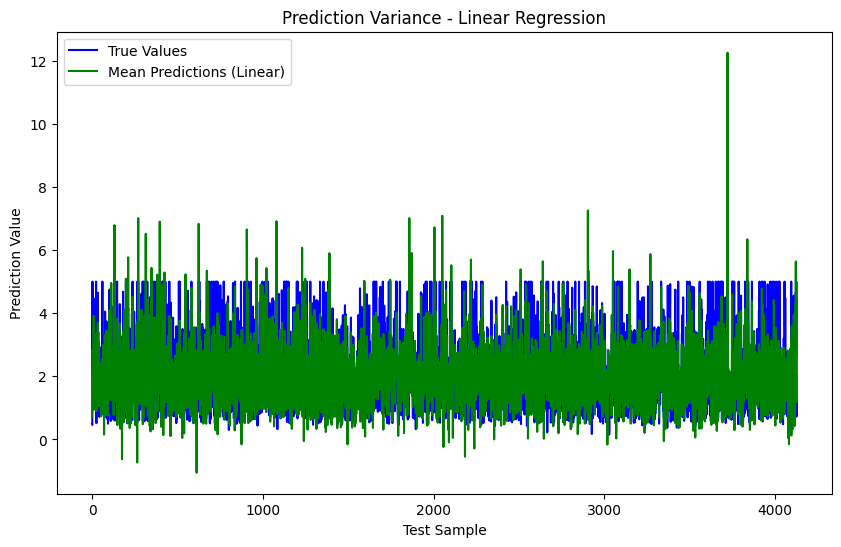

Variance of Predictions (Linear Regression): 1.7593328238846822e-29


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

# Function to create bootstrap samples and train models
def create_bootstrap_models(X_train, y_train, n_samples=100):
    models = []
    for _ in range(n_samples):
        # Create bootstrap sample
        X_resample, y_resample = resample(X_train, y_train, random_state=42)
        
        # Train linear regression model
        model = LinearRegression()
        model.fit(X_resample, y_resample)
        models.append(model)
    
    return models

# Create models
models_lr = create_bootstrap_models(X_train, y_train, n_samples=100)

# Get predictions for each model on the test set
y_preds_lr = np.array([model.predict(X_test) for model in models_lr])

# Calculate mean and variance of predictions
mean_preds_lr = np.mean(y_preds_lr, axis=0)
var_preds_lr = np.var(y_preds_lr, axis=0)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values', color='blue')
plt.plot(mean_preds_lr, label='Mean Predictions (Linear)', color='green')
plt.title("Prediction Variance - Linear Regression")
plt.xlabel("Test Sample")
plt.ylabel("Prediction Value")
plt.legend()
plt.show()

# Show variance across predictions
print("Variance of Predictions (Linear Regression):", np.mean(var_preds_lr))


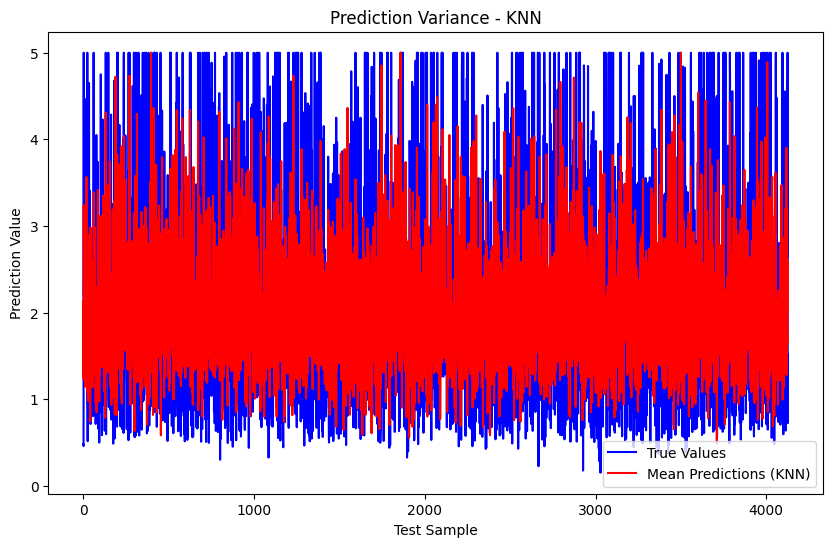

Variance of Predictions (KNN): 8.937011411971548e-30


In [7]:
from sklearn.neighbors import KNeighborsRegressor

# Function to create bootstrap samples and train models with KNN
def create_bootstrap_knn(X_train, y_train, n_samples=100, k_neighbors=5):
    models = []
    for _ in range(n_samples):
        # Create bootstrap sample
        X_resample, y_resample = resample(X_train, y_train, random_state=42)
        
        # Train KNN model
        model = KNeighborsRegressor(n_neighbors=k_neighbors)
        model.fit(X_resample, y_resample)
        models.append(model)
    
    return models

# Create KNN models
models_knn = create_bootstrap_knn(X_train, y_train, n_samples=100)

# Get predictions for each model on the test set
y_preds_knn = np.array([model.predict(X_test) for model in models_knn])

# Calculate mean and variance of predictions
mean_preds_knn = np.mean(y_preds_knn, axis=0)
var_preds_knn = np.var(y_preds_knn, axis=0)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values', color='blue')
plt.plot(mean_preds_knn, label='Mean Predictions (KNN)', color='red')
plt.title("Prediction Variance - KNN")
plt.xlabel("Test Sample")
plt.ylabel("Prediction Value")
plt.legend()
plt.show()

# Show variance across predictions
print("Variance of Predictions (KNN):", np.mean(var_preds_knn))


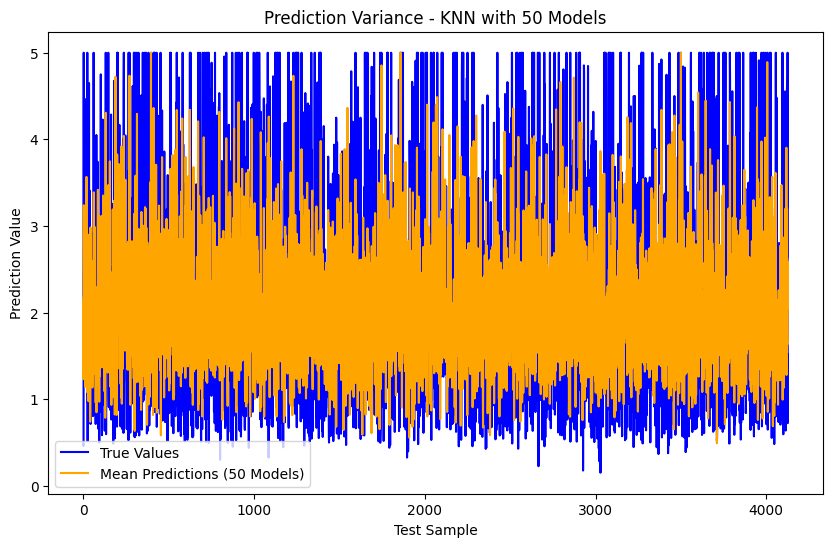

Variance of Predictions (50 Models): 2.066708704961672e-30


In [8]:
# Train with a smaller number of bootstrap samples (e.g., 50 models)
models_50 = create_bootstrap_knn(X_train, y_train, n_samples=50)
y_preds_50 = np.array([model.predict(X_test) for model in models_50])
mean_preds_50 = np.mean(y_preds_50, axis=0)
var_preds_50 = np.var(y_preds_50, axis=0)

# Plot results for 50 models
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values', color='blue')
plt.plot(mean_preds_50, label='Mean Predictions (50 Models)', color='orange')
plt.title("Prediction Variance - KNN with 50 Models")
plt.xlabel("Test Sample")
plt.ylabel("Prediction Value")
plt.legend()
plt.show()

# Show variance
print("Variance of Predictions (50 Models):", np.mean(var_preds_50))


### Bagging Implementation

- In order to improve the MSE and reduce the variance of the results implement your own Bagging class.

- Recall that Bagging is performed when all predictors (i.e. covariates - features) are used.

In [1]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils import resample

class MyBagging(BaseEstimator, RegressorMixin):
    def __init__(self, base_estimator, n_estimators=100, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.models = []

        # Train multiple models on bootstrap samples
        for _ in range(self.n_estimators):
            # Create bootstrap sample
            X_resample, y_resample = resample(X, y, random_state=self.random_state)
            model = self.base_estimator
            model.fit(X_resample, y_resample)
            self.models.append(model)
        
        return self

    def predict(self, X):
        # Get predictions from each model
        predictions = np.zeros((self.n_estimators, X.shape[0]))
        for i, model in enumerate(self.models):
            predictions[i] = model.predict(X)
        
        # Average the predictions
        return np.mean(predictions, axis=0)


Load Data: Split dataset into features and target, then split into training and test sets.

Base Learner: Use a Decision Tree Regressor as the weak model.

Bagging: Use Bagging Regressor to create an ensemble of decision trees.

Train: Fit the bagging model on the training data.

Predict: Use the trained model to make predictions on the test set.

Evaluate: Check performance using metrics like MSE and R².

Tune: Adjust the number of trees or tree depth for better results.

- Fit your Bagging regressor to the training data. Compare it to `DecisionTree` Sklearn built-in class.

To compare the performance of your custom Bagging Regressor with the built-in DecisionTreeRegressor from sklearn, follow these steps:

Train Your Bagging Regressor: Use the custom Bagging class with multiple decision trees and fit it on your training data.

Train a Built-in Decision Tree Regressor: Use the built-in DecisionTreeRegressor from sklearn, which trains a single decision tree on the data.

Make Predictions: Use both models to make predictions on the test set.

Evaluate Performance: Compare the performance of both models using metrics like Mean Squared Error (MSE) and R² Score to see which model performs better.

Expected Results:
Bagging Regressor: Should perform better by reducing variance and overfitting, as it combines predictions from multiple decision trees.

Decision Tree Regressor: Likely to overfit, especially on small datasets, since it only uses one decision tree.

- Effect of Increasing Trees in Bagging : 
    - Vizualize the effect of increasing the number of weak learners. 
    - Does increasing the number of trees always help ?

Increasing the number of trees in Bagging typically improves model performance by reducing variance. However, after a certain threshold, the improvements become smaller, and adding more trees can lead to higher computational costs without significant gains in accuracy.

### Random Forest
Random Forest introduces additional randomness by restricting the number of features that each tree can consider when splitting a node.

Usually, $\sqrt{p}$ features for classification and $p/3$ for regression, where $p$ is the total number of features.

This restriction decorrelates the trees, reducing the chance of overfitting even further.

- Modify your class to chose the maximum number of features to consider when searching for the best split. 

The modified **RandomForest-like Bagging** class introduces a `max_features` parameter that limits the number of features considered for each split in a decision tree. By default, for regression tasks, it is set to \( p/3 \), where \( p \) is the number of features. This restriction introduces randomness and reduces correlation between trees, improving the model's generalization ability and preventing overfitting. You can adjust `max_features` to explore different levels of feature randomness and observe its impact on model performance.

- Create a plot displaying the test, train and OOB error resulting from random forests for a more comprehensive range of values for max_features and n_estimators
- Describe the results obtained

Setup the Random Forest with OOB Error: We'll enable the oob_score=True parameter in the Random Forest model to compute OOB error.

Vary max_features and n_estimators: We will loop through different values for max_features (such as 'auto', 'sqrt', and a few numbers) and n_estimators (such as 50, 100, 200).

Track Train, Test, and OOB Errors: For each combination of max_features and n_estimators, we will calculate the train, test, and OOB errors.

Plot the results: Create a plot showing these errors for different values of n_estimators and max_features.

- Visualize the difference in variance between your Decision Tree and Random Forest (which you can replicate with different parameters).

Decision Tree: We’ll train a Decision Tree on the same dataset.

Random Forest: We’ll train a Random Forest using different numbers of trees (n_estimators) and features (max_features) to showcase how the variance changes with more trees and the randomness introduced by bootstrapping.

Visualization: We’ll plot the train error, test error, and variance for both models. Variance can be represented as the difference between the training error and test error (higher variance means a large difference).

--- 